In [1]:
!which python

/Applications/anaconda/envs/sherpa411/bin/python


In [2]:
!python --version

Python 3.6.8 :: Anaconda, Inc.


In [3]:
import sys
sys.executable = '/Applications/anaconda/envs/sherpa411/bin/python'
sys.path = ['', '/Applications/heasoft-6.24/x86_64-apple-darwin17.4.0/lib/python', 
            '/Applications/heasoft-6.24/x86_64-apple-darwin17.4.0/lib', 
            '/Applications/anaconda/envs/sherpa411/lib/python36.zip', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6/lib-dynload', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages/sherpa-4.11.0+0.g838bd12b.dirty-py3.6-macosx-10.9-x86_64.egg']

In [4]:
import numpy as np
from astropy.table import Table, Column, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import powerlaw
from scipy import integrate
from scipy.special import gammaln
import time
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
%matplotlib inline

In [5]:
import sherpa.astro.ui as ui
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [7]:
!pwd

/Users/mlazz/Dropbox/UW/PileupABC/PileupABC/Margaret


In [8]:
!ls

__pycache__                    mcmc_heatmap.pdf
abc.ipynb                      metropolis_hastings_mcmc.ipynb
abc_initial_results.pdf        part1_fake_data.txt
abc_part1.pdf                  part2_fake_data.txt
abc_part1.py                   part3_fake_data.txt
abc_part2.pdf                  part3_parameters.txt
abc_part2_combo.pdf            pileup_testmodel.ipynb
alpha_comparison.pdf           real_data.fits
alpha_mcmc_abc.pdf             real_data.txt
auto_corr.py                   sherpa_practice.ipynb
auto_corr.pyc                  simdat.py
bayes.py                       simdat.pyc
bayes.pyc                      spectrum.pdf
data                           spectrum_sim.pyc
dfm_autocorr.ipynb             spectrum_unpiled.pdf
fake_acis.pha


In [63]:
datadir = "./"
ui.load_data(id="p1", filename=datadir+"fake_acis.pha");

statistical errors were found in file './fake_acis.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file arfs/aciss_hetg0_cy19.arf
read RMF file rmfs/aciss_hetg0_cy19.rmf


In [11]:
d = ui.get_data("p1")

In [13]:
# conversion factor from keV to angstrom
c = 12.3984191

# This is the data in angstrom
bin_lo = d.bin_lo
bin_hi = d.bin_hi
bin_mid = bin_lo + (bin_hi - bin_lo) / 2.0

counts = d.counts

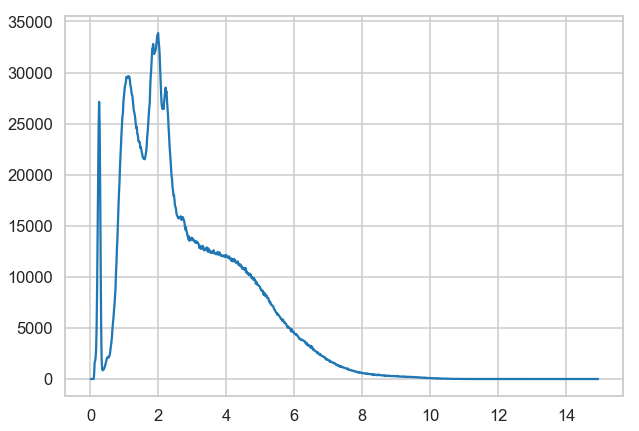

In [14]:
plt.figure(figsize=(10,7))
plt.plot(bin_mid, counts)

In [12]:
arf = d.get_arf() # get out an ARF object
rmf = d.get_rmf() # get out an RMF object

In [15]:
exposure = arf.exposure # exposure time in seconds
specresp = arf.specresp # the actual response in the ARF, i.e. effective area + stuff

In [16]:
energ_lo = arf.energ_lo
energ_hi = arf.energ_hi

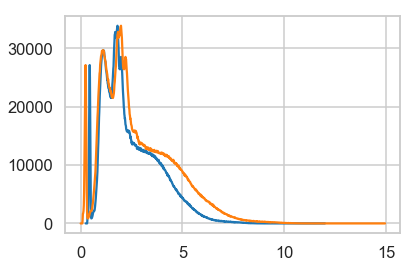

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(energ_lo, counts)
ax.plot(bin_lo, counts)

In [18]:
from sherpa.astro import xspec

In [19]:
xspec.get_xsversion()

'12.10.0c'

In [20]:
xspec.get_xschatter()

0

In [21]:
pl = xspec.XSpowerlaw()

In [22]:
pl.norm=10.0
pl.PhoIndex = 2.0

In [23]:
m = pl(energ_lo, energ_hi)

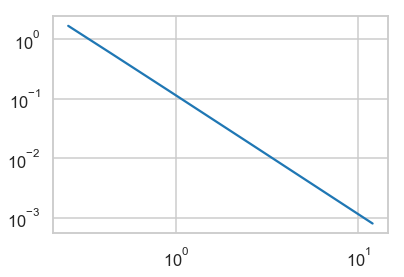

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(energ_lo, m)

In [25]:
m_arf = arf.apply_arf(m)*exposure

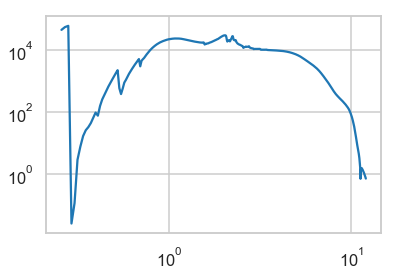

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(energ_lo, m_arf)

In [27]:
m_rmf = rmf.apply_rmf(m_arf)

(1.0, 2.5)

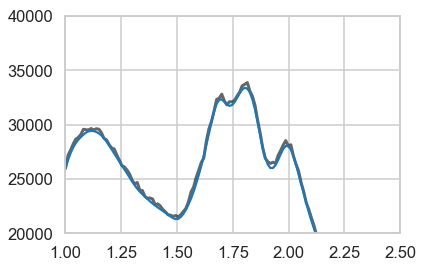

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(energ_lo, counts, color="black", lw=3, alpha=0.6)
ax.plot(energ_lo, m_rmf)
ax.set_ylim(20000,40000)
ax.set_xlim(1.0,2.5)

# Ok, let's simulate spectrum with pile up!
* Note: does pile up get applied before or after RMF? Daniela and I are still not sure...

In [33]:
norm = 0.005 # input power law normalization
PhoIndex = 1.7 # input power law photon index (is negative by default)

In [34]:
print(exposure)

9914.9001034498


In [35]:
pl = xspec.XSpowerlaw()
pl.norm = norm
pl.PhoIndex = PhoIndex

base_model = pl(energ_lo, energ_hi)

In [36]:
base_arf = arf.apply_arf(base_model)*exposure
base_spec = rmf.apply_rmf(base_arf)

In [37]:
np.random.seed(200) # set the seed for reproducibility

In [38]:
nphot = np.random.poisson(np.sum(base_spec))
print("The total number of photons is %i"%nphot)

The total number of photons is 4200


In [39]:
tstart = 0
tend = tstart + exposure

phot_times = np.random.uniform(tstart, tend, size=nphot)

phot_times = np.sort(phot_times)

In [40]:
#use the spectrum as a cumulative distribution function and use it to sort photons (with given arrival times)
#into energy bins
spec_pdf = base_spec/np.sum(base_spec)

In [41]:
phot_energies = np.random.choice(energ_lo, size=nphot, replace=True, p=spec_pdf)

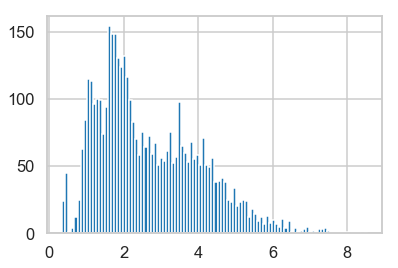

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(phot_energies, bins=100);

In [44]:
frametime = 3.2 # frame read-out interval in seconds

In [46]:
intervals = np.arange(tstart, tend+frametime, frametime) #set the times that the detector will be read

In [47]:
import scipy.stats

In [48]:
summed_erg, bins, bin_idx = scipy.stats.binned_statistic(phot_times, phot_energies, bins=intervals, statistic="sum")

In [57]:
print(summed_erg)

[ 6.53427255 10.58308601  1.34462404  4.4643898   3.83622074  4.01973629
  6.1989845   3.79034173  2.4915967   3.29447746  2.80127931  7.43771482
 10.55134273  5.86636233  2.20485353  4.36382806  2.27367187  1.61989748
  1.60842776  1.5740186   3.47799325  7.04774427  5.16937506  3.47799325
  3.80181158  2.25339842  0.87436521  3.65270507  1.33315432  3.27420413
  5.13229978  4.06561518  3.46918952  3.36596191  4.44145012  5.39343739
  5.198452    5.31581545  2.36542964  9.63990211  1.43638182  1.47079098
  6.91277349  2.09015632  4.1803124   8.06854963  4.17764664  5.30434573
  4.79967785  4.01973629  3.33155286  3.83355474  5.59108889  4.3179493
  3.98532724  1.47079098  1.9869287   1.25286627  1.28727543  6.78660649
  6.54574236  5.46225595  6.04107434  1.14963865 10.08988786  1.3216846
  6.57748544 10.07841778  2.02133799  2.63189936  1.0693506   3.71271974
  0.96612304  6.40543938  6.8183496   5.26993668  2.69805169 11.16804218
  7.38036638  2.83568859  7.93091297  3.92531252  1.8

In [59]:
print(bin_idx)

[   1    1    1    2    2    2    3    6    7    7    8    8    9    9
   11   11   12   14   15   17   17   18   18   18   18   19   19   20
   22   22   23   24   25   28   29   30   30   31   31   31   32   33
   33   35   35   37   38   38   39   40   40   42   42   44   44   46
   46   47   47   48   49   50   51   51   52   53   53   54   55   56
   56   56   58   59   59   61   61   62   63   63   64   64   66   66
   67   67   68   69   69   70   70   70   70   71   71   73   73   74
   75   76   78   79   79   79   80   80   80   81   82   82   82   83
   84   84   84   85   86   86   87   87   87   88   90   90   91   92
   92   92   93   94   94   95   95   97   97   99  100  100  100  101
  101  102  103  103  105  107  108  108  108  109  109  110  110  111
  113  113  114  115  115  116  118  118  119  119  120  121  124  124
  126  126  127  128  130  130  130  132  132  132  133  133  134  135
  135  135  137  138  139  141  141  142  144  145  145  146  146  147
  147 

In [49]:
n_per_bin = np.bincount(bin_idx-1) # bin_idx is one-indexed for reasons I don't understand!

In [50]:
phot_per_bin, bins2 = np.histogram(phot_times, bins=intervals)

In [51]:
summed_erg = summed_erg[(summed_erg > 0) & (summed_erg < np.max(energ_hi))]

In [52]:
energ_intervals = np.hstack([energ_lo, energ_hi[-1]])


In [62]:
energ_intervals[:-1]

array([ 0.255     ,  0.26646972,  0.27793944,  0.28940919,  0.30087891,
        0.31234863,  0.32381836,  0.33528808,  0.3467578 ,  0.35822755,
        0.36969727,  0.38116699,  0.39263672,  0.40410644,  0.41557616,
        0.42704591,  0.43851563,  0.44998536,  0.46145508,  0.4729248 ,
        0.48439452,  0.49586427,  0.50733399,  0.51880372,  0.53027344,
        0.54174316,  0.55321288,  0.5646826 ,  0.57615232,  0.58762205,
        0.59909177,  0.61056155,  0.62203127,  0.63350099,  0.64497072,
        0.65644044,  0.66791016,  0.67937988,  0.6908496 ,  0.70231932,
        0.71378905,  0.72525877,  0.73672849,  0.74819827,  0.75966799,
        0.77113771,  0.78260744,  0.79407716,  0.80554688,  0.8170166 ,
        0.82848632,  0.83995605,  0.85142577,  0.86289549,  0.87436521,
        0.88583493,  0.89730471,  0.90877444,  0.92024416,  0.93171388,
        0.9431836 ,  0.95465332,  0.96612304,  0.97759277,  0.98906249,
        1.00053227,  1.01200199,  1.02347171,  1.03494143,  1.04

In [61]:
energ_lo

array([ 0.255     ,  0.26646972,  0.27793944,  0.28940919,  0.30087891,
        0.31234863,  0.32381836,  0.33528808,  0.3467578 ,  0.35822755,
        0.36969727,  0.38116699,  0.39263672,  0.40410644,  0.41557616,
        0.42704591,  0.43851563,  0.44998536,  0.46145508,  0.4729248 ,
        0.48439452,  0.49586427,  0.50733399,  0.51880372,  0.53027344,
        0.54174316,  0.55321288,  0.5646826 ,  0.57615232,  0.58762205,
        0.59909177,  0.61056155,  0.62203127,  0.63350099,  0.64497072,
        0.65644044,  0.66791016,  0.67937988,  0.6908496 ,  0.70231932,
        0.71378905,  0.72525877,  0.73672849,  0.74819827,  0.75966799,
        0.77113771,  0.78260744,  0.79407716,  0.80554688,  0.8170166 ,
        0.82848632,  0.83995605,  0.85142577,  0.86289549,  0.87436521,
        0.88583493,  0.89730471,  0.90877444,  0.92024416,  0.93171388,
        0.9431836 ,  0.95465332,  0.96612304,  0.97759277,  0.98906249,
        1.00053227,  1.01200199,  1.02347171,  1.03494143,  1.04

In [53]:
spec_nopileup, spec_bins = np.histogram(phot_energies, bins=energ_intervals)
spec_pileup, spec_bins = np.histogram(summed_erg, bins=energ_intervals)

Text(0, 0.5, 'Number of photons per bin')

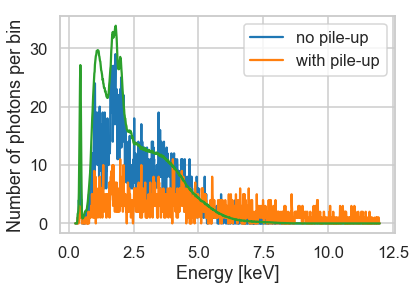

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(energ_lo, spec_nopileup, label="no pile-up")
ax.plot(energ_lo, spec_pileup, label="with pile-up")
ax.plot(energ_lo, d.counts/1000)
ax.legend()

ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Number of photons per bin")

In [55]:
pileup_fraction = len(n_per_bin[n_per_bin > 1])/len(n_per_bin)

In [56]:
print("%.2f of the frames have piled events in them."%pileup_fraction)

0.38 of the frames have piled events in them.
